In [1]:
# %%capture
# !pip install torch numpy pandas matplotlib scikit-learn

# !pip install git+https://github.com/gretelai/gretel-synthetics.git

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.0 kB ? eta -:--:--
     ------------------------------------- 165.0/165.0 kB 10.3 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached pillow-10.3.0-cp39-cp39-win_amd64.whl.metadata (9.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ----------

  Running command git clone --filter=blob:none --quiet https://github.com/gretelai/gretel-synthetics.git 'C:\Users\lia68085\AppData\Local\Temp\pip-req-build-lmn7h_m9'


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import json
import torch
from pathlib import Path

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType



# Dataanalyse

In [3]:
datapath='../Dataanalyse/all_data_axis1.csv'
df=pd.read_csv(datapath)
df.drop_duplicates(subset=[df.columns[0]], inplace=True)

df.shape

(1771047, 31)

In [44]:
import json
def getdata(path, length,axis):
    
    """
    This function reads a CSV file, filters important features based on a JSON file, and returns subsets of data.

    Args:
        path (str): Path to the CSV file containing the dataset.
        length (int): The threshold length for filtering time-related data.
        axis (str): The axis identifier (e.g., 'axis1', 'axis2') used to select the appropriate JSON file with feature importance.

    Returns:
        list: A list of DataFrames, each containing the data for a specific time where the number of rows is greater than the given length.
    
    Process:
        1. Reads the CSV file and the JSON file with the most important features.
        2. Creates a new DataFrame based on the selected features, including the timestamp.
        3. Converts the 'Timestamp' column to datetime.
        4. Iterates through all unique timestamps and appends the data where the number of rows exceeds the length threshold.
    """
    df=pd.read_csv(path)
    with open (f'feature_important_{axis}.json', 'r') as f:
        importance = json.load(f)[:10]
    importance=['Timestamp']+importance
    
    newdf=df[importance]
    newdf=newdf.copy()
    newdf['Timestamp'] = pd.to_datetime(newdf['Timestamp'], unit='s')
    difftiem=np.unique(newdf['Timestamp']) 
    data=[]
    for time in difftiem:
        length_of_data=len(newdf[newdf['Timestamp']==time])
        if length_of_data>length:
            slidedata=newdf[newdf['Timestamp']==time].copy()
            data.append(slidedata)

    return data


    
def dataconcatente(listdata, length):
     
    """
    This function concatenates multiple time-based data segments into a NumPy array of a specific shape for further processing.

    Args:
        listdata (list): A list of DataFrames, each representing time-related sensor data.
        length (int): The length to segment each DataFrame before reshaping.

    Returns:
        numpy.ndarray: A concatenated 3D NumPy array, where each segment has the shape (length, 10).
    
    Process:
        1. Initializes an empty NumPy array named 'two' with the target shape.
        2. Iterates over each DataFrame in the provided list, removes the 'Timestamp' column, and reshapes the data.
        3. Reshapes each DataFrame into 3D form, then concatenates it into the main NumPy array.
        4. Outputs information about the shapes during concatenation for debugging purposes.
    """


    two = np.empty((0, length, 10))

    for i, data in enumerate(listdata):

        sensor_df=data
        all_column = list(sensor_df.columns)
        all_column.remove('Timestamp')
        train_df=sensor_df
        train_df =pd.DataFrame(train_df)
        train_df = train_df.drop(columns="Timestamp").to_numpy()
        n = train_df.shape[0] // length
        train_df = train_df[:(n*length),:].reshape(-1, length, train_df.shape[1])
        print(train_df.shape)
        two = np.concatenate((two, train_df), axis=0)
        print(two.shape)
        print('*'*20)
    return two

In [45]:
data=getdata(datapath,2000,'axis1')
len(data)

182

In [ ]:
final=dataconcatente(data,2000)
final.shape

In [47]:
x=list(data[0].columns)
feat = list(data[0].columns)
feat.remove('Timestamp')
feat

['Effektivwert_z',
 'Median_z',
 'Mittlere_Absolute_Abweichung_z',
 'Mittelwert_z',
 'Median_y',
 'Effektivwert_y',
 'Effektivwert_x',
 'Variance_z',
 'Mittelwert_x',
 'Standardabweichung_z']

In [50]:
max_sequence_len=final.shape[1]
max_sequence_len

2000

In [30]:
import time
import pickle

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=final.shape[1],
    sample_len=1000,
    batch_size=32,
    apply_feature_scaling=True,
    apply_example_scaling=True,
    use_attribute_discriminator=True,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=250,
))

model.train_numpy(
    final,
    feature_types=[OutputType.CONTINUOUS] * final.shape[2],
)

# Save the trained model
model.save('dgan_model_10000_axis2.pkl')
_,synthetic_features = model.generate_numpy(30)
synthetic_features=np.array(synthetic_features)
with open('synthetic_data_10000_axis2.pkl', 'wb') as f:
    pickle.dump(synthetic_features, f)

In [51]:
import pickle
# Load the synthetic data
with open('synthetic_data_2000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
synthetic_features.shape

(300, 2000, 10)

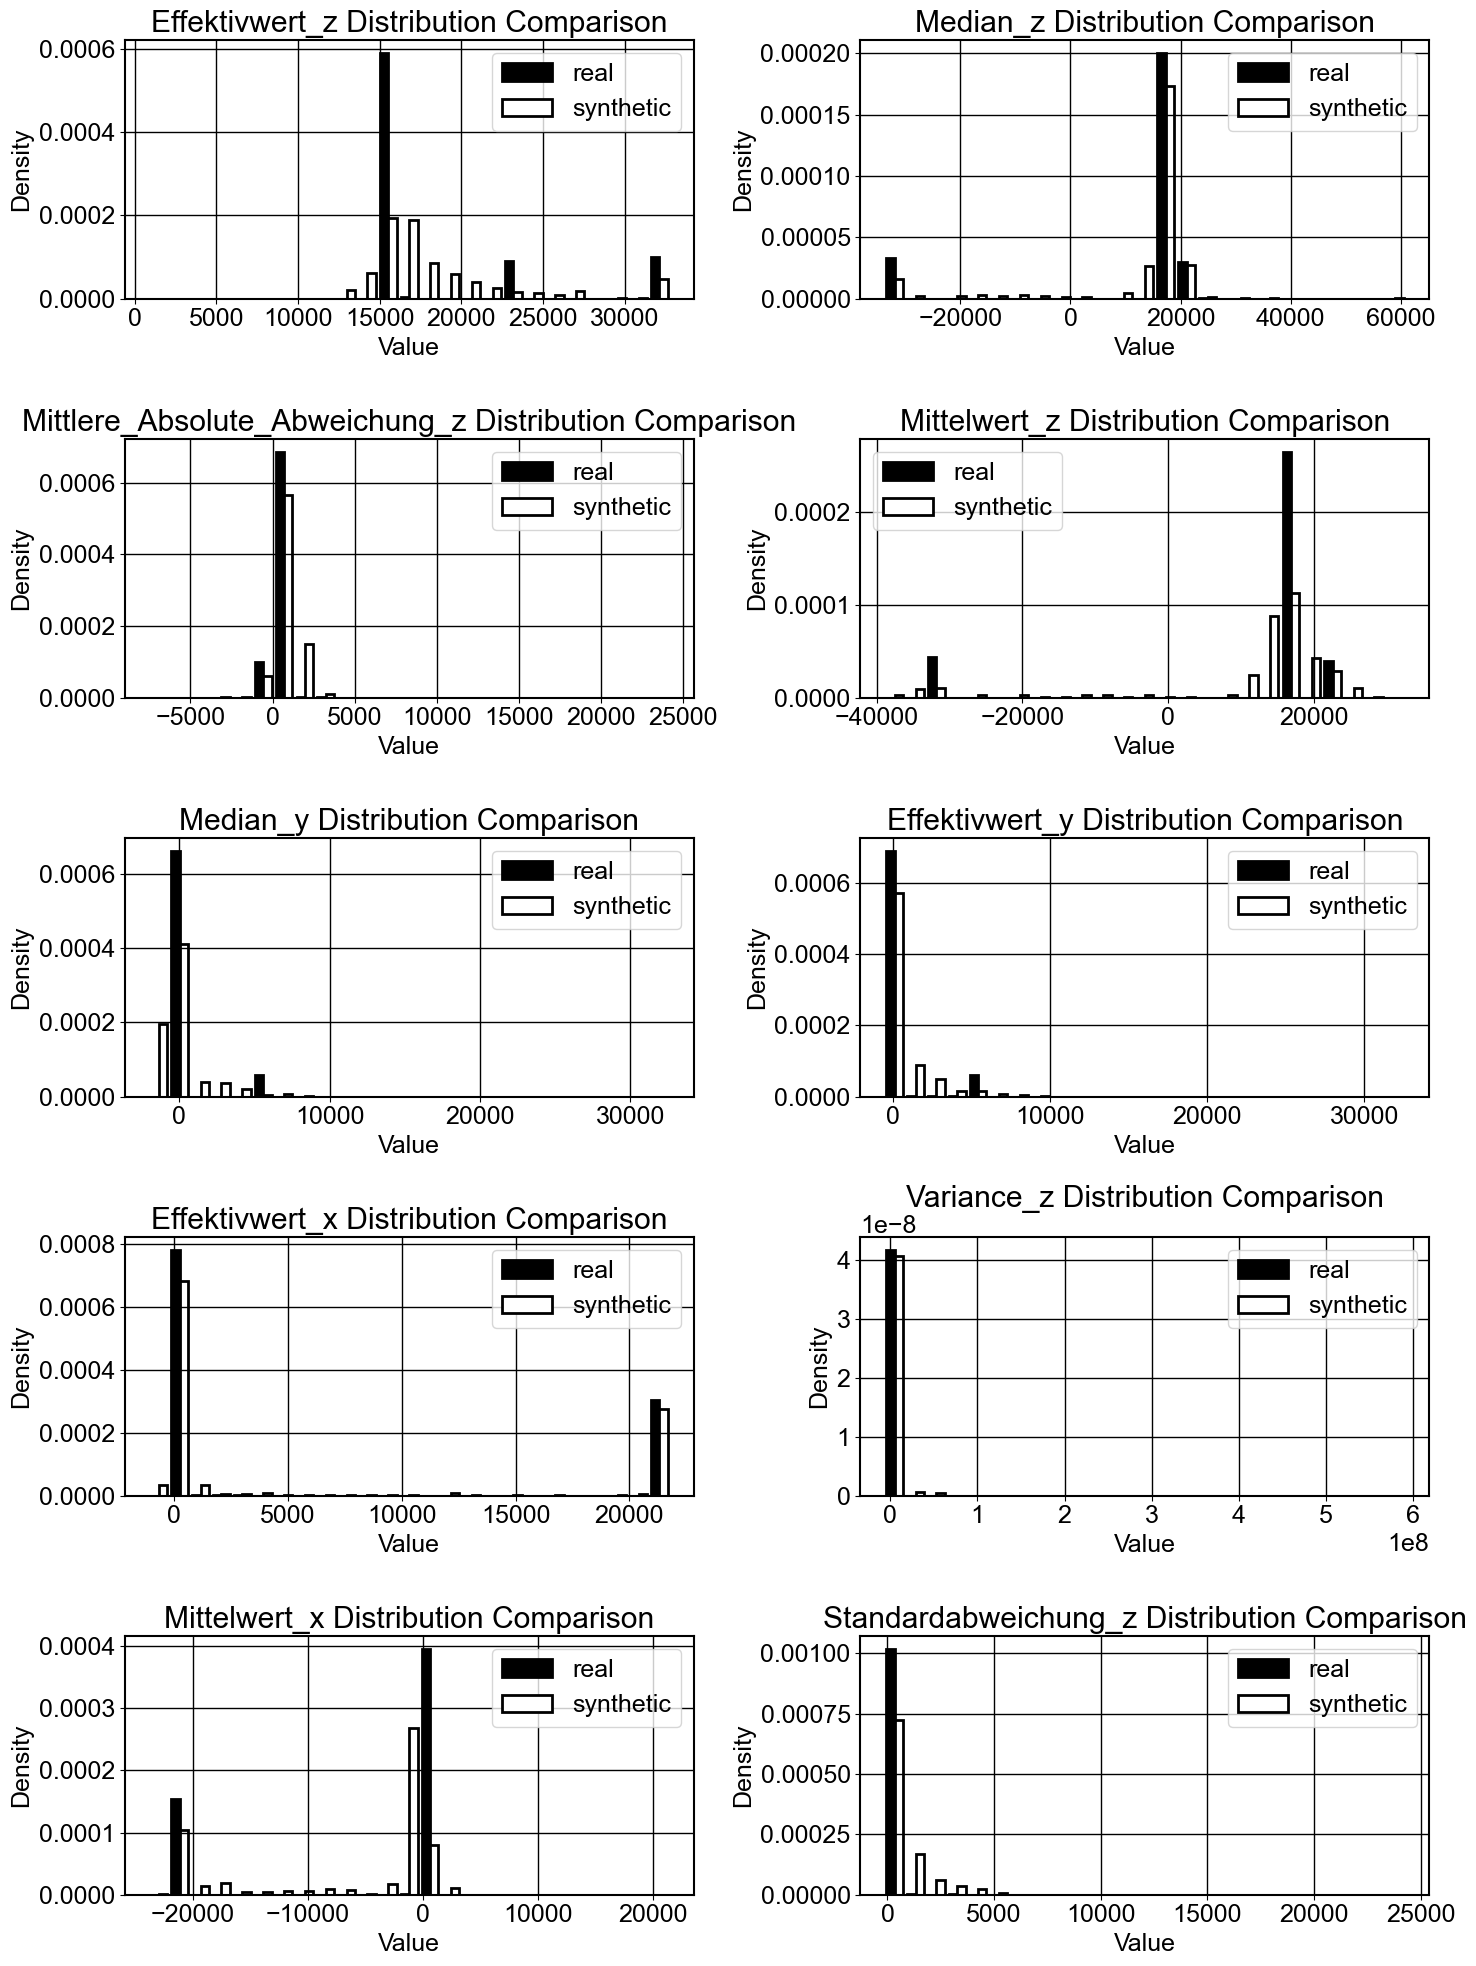

<Figure size 640x480 with 0 Axes>

In [61]:
import numpy as np
import matplotlib.pyplot as plt

final = final
synthetic_features = synthetic_features

columns=data[2].columns[1:]
columns

num_features = synthetic_features.shape[-1]
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

n_cols = 2  # number of columns
n_rows = (num_features + n_cols - 1) // n_cols  # calculate the number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# compare the distribution of each feature
for i in range(num_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]


    ax.hist([final[:,:,i].flatten(), synthetic_features[:,:,i].flatten()], 
            label=["real", "synthetic"],
            bins=25,
            density=True,
            edgecolor='black',
            linewidth=2,
            color=['black', 'white']
            )
    ax.legend()
    ax.grid(True, linewidth=1.0, color='black')  # add grid lines

    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{columns[i]} Distribution Comparison")
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

# remove extra subplots
for i in range(num_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# adjust the layout
plt.tight_layout()
plt.savefig('distribution_comparison_axis2_2000.jpg')
plt.show()


In [30]:
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=data[2].columns[1:])
synthetic_df

,Effektivwert_z,Median_z,Mittlere_Absolute_Abweichung_z,Mittelwert_z,Median_y,Effektivwert_y,Effektivwert_x,Variance_z,Mittelwert_x,Standardabweichung_z
0,13939.009766,21030.402344,1308.211670,17277.109375,1010.787109,1276.927734,20346.619141,12328100.0,-16969.375000,886.312500
1,13862.076172,21020.027344,1321.467651,17220.421875,907.935303,1219.153564,20392.701172,13458755.0,-16939.951172,923.019409
2,13894.307617,21022.558594,1285.380859,17250.023438,1010.308350,1301.046997,20378.734375,13134255.0,-16945.289062,945.231873
3,13878.738281,21337.906250,1313.531128,17277.574219,1080.265869,1211.750610,20349.361328,12526677.0,-16908.394531,868.712158
4,13915.550781,21118.734375,1325.578247,17304.449219,1199.155273,1410.306274,20381.224609,13421669.0,-16913.527344,850.431152
...,...,...,...,...,...,...,...,...,...,...
499995,21858.548828,4632.273438,255.979080,4670.085938,-689.962341,1073.596802,400.452728,6360842.5,945.587891,328.705811
499996,21860.375000,4580.570312,298.571411,4614.785156,-717.921326,1039.573364,416.409576,6949232.0,936.277344,405.386597
499997,21834.052734,4578.906250,277.177673,4540.761719,-734.195374,1016.322021,427.939819,6962788.0,940.738281,288.685394
499998,21882.958984,4475.980469,299.355286,4516.101562,-654.090271,1021.138794,427.195862,6690855.0,957.644531,322.448334


In [91]:
final.shape

(1131, 2000, 10)

In [31]:
synthetic_features.shape

(50, 10000, 10)

 # axis1 2000 features["Effektivwert_z","Median_z", "Mittlere_Absolute_Abweichung_z", "Mittelwert_z", "Median_y", "Effektivwert_y", "Effektivwert_x", "Variance_z", "Mittelwert_x", "Standardabweichung_z"]

In [27]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import json 
import pickle
import pandas as pd
import numpy as np
# Load the synthetic data
with open('synthetic_data_2000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
print(synthetic_features.shape)
with open ('feature_important_axis1.json', 'r') as f:
    importance = json.load(f)
print(importance)
# get current time
current_time = datetime.now()

# generate a list of UNIX timestamps where each batch of timestamps is one hour apart
timestamps = [(current_time + timedelta(hours=i)).timestamp() for i in range(synthetic_features.shape[0])]

# add UNIX timestamps to each batch 
# reshape the timestamps to match the synthetic_features
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))

# combine timestamps and synthetic features
synthetic_features_with_timestamps = np.concatenate((timestamp_array, synthetic_features), axis=2)

# reshape the synthetic features to 2D
reshaped_features = synthetic_features_with_timestamps.reshape(-1, synthetic_features_with_timestamps.shape[2])
columns =['Timestamp']+ importance

# create a DataFrame
synthetic_df = pd.DataFrame(reshaped_features, columns=columns)

print(synthetic_df)
synthetic_df.to_csv('synthetic_data_2000_axis1.csv', index=False)

(300, 2000, 10)
['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z', 'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x', 'Variance_z', 'Mittelwert_x', 'Standardabweichung_z']
           Timestamp  Effektivwert_z      Median_z  \
0       1.721476e+09    16583.060547  14809.136719   
1       1.721476e+09    16582.994141  14808.652344   
2       1.721476e+09    16582.958984  14809.625000   
3       1.721476e+09    16582.958984  14809.375000   
4       1.721476e+09    16582.943359  14809.921875   
...              ...             ...           ...   
599995  1.722553e+09    13483.210938  16318.375000   
599996  1.722553e+09    13480.842773  16319.394531   
599997  1.722553e+09    13478.639648  16322.644531   
599998  1.722553e+09    13479.916992  16320.660156   
599999  1.722553e+09    13479.846680  16320.769531   

        Mittlere_Absolute_Abweichung_z  Mittelwert_z    Median_y  \
0                           112.215935  14589.859375  -40.987061   
1               

# axis1 10000 features["Effektivwert_z","Median_z", "Mittlere_Absolute_Abweichung_z", "Mittelwert_z", "Median_y", "Effektivwert_y", "Effektivwert_x", "Variance_z", "Mittelwert_x", "Standardabweichung_z"]

In [29]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import json 
import pickle
import pandas as pd
import numpy as np
# Load the synthetic data
with open('synthetic_data_10000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
print(synthetic_features.shape)
with open ('feature_important_axis1.json', 'r') as f:
    importance = json.load(f)
print(importance)
# get current time
current_time = datetime.now()

# generate a list of UNIX timestamps where each batch of timestamps is one hour apart
timestamps = [(current_time + timedelta(hours=i)).timestamp() for i in range(synthetic_features.shape[0])]

# add UNIX timestamps to each batch 
# reshape the timestamps to match the synthetic_features
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))

# combine timestamps and synthetic features
synthetic_features_with_timestamps = np.concatenate((timestamp_array, synthetic_features), axis=2)

# reshape the synthetic features to 2D
reshaped_features = synthetic_features_with_timestamps.reshape(-1, synthetic_features_with_timestamps.shape[2])
columns =['Timestamp']+ importance

# create a DataFrame
synthetic_df = pd.DataFrame(reshaped_features, columns=columns)

print(synthetic_df)
synthetic_df.to_csv('synthetic_data_10000_axis1.csv', index=False)

(50, 10000, 10)
['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z', 'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x', 'Variance_z', 'Mittelwert_x', 'Standardabweichung_z']
           Timestamp  Effektivwert_z      Median_z  \
0       1.721477e+09    13939.009766  21030.402344   
1       1.721477e+09    13862.076172  21020.027344   
2       1.721477e+09    13894.307617  21022.558594   
3       1.721477e+09    13878.738281  21337.906250   
4       1.721477e+09    13915.550781  21118.734375   
...              ...             ...           ...   
499995  1.721653e+09    21858.548828   4632.273438   
499996  1.721653e+09    21860.375000   4580.570312   
499997  1.721653e+09    21834.052734   4578.906250   
499998  1.721653e+09    21882.958984   4475.980469   
499999  1.721653e+09    21877.109375   4556.238281   

        Mittlere_Absolute_Abweichung_z  Mittelwert_z     Median_y  \
0                          1308.211670  17277.109375  1010.787109   
1             